In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import lightgbm as lgb
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
import shap
import datetime
import joblib
import streamlit as st
import folium
from streamlit_folium import st_folium
import requests
import warnings
warnings.filterwarnings("ignore")


d:\Machine learning\tf-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-12 00:01:36.465 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [3]:
df = pd.read_csv(r'D:\Machine learning\ML Project\Nyc_taxi_fare_prediction\Data\train.csv',nrows=1000)
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
df.isnull().sum().sum()

np.int64(0)

#  Basic Data Cleaning

In [5]:
df.dropna(inplace=True) # Drop rows with any NaN values

In [6]:
df = df[df['fare_amount'] >= 0] # Remove negative fare amounts

In [7]:
df = df[(df['pickup_latitude'].between(-90, 90)) &
     (df['pickup_longitude'].between(-180, 180)) &
     (df['dropoff_latitude'].between(-90, 90)) &
     (df['dropoff_longitude'].between(-180, 180))]

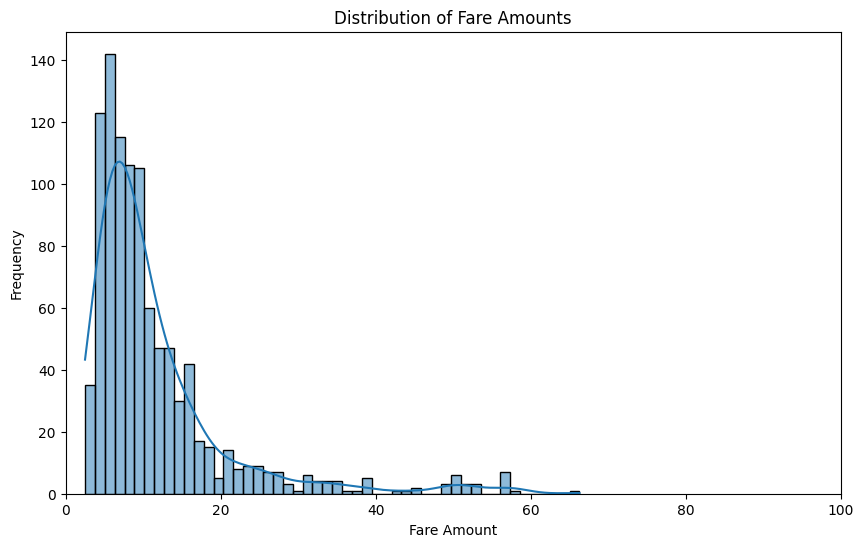

In [8]:
plt.figure(figsize=(10,6))
sns.histplot(df['fare_amount'], bins=50, kde=True)
plt.title('Distribution of Fare Amounts')
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.xlim(0, 100)
plt.show()

In [9]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance in kilometers between two points on the Earth
    specified in decimal degrees.
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371  # Radius of Earth in kilometers
    return c * r

In [10]:
df['distance_km'] = haversine(df['pickup_latitude'], df['pickup_longitude'],
                               df['dropoff_latitude'], df['dropoff_longitude'])

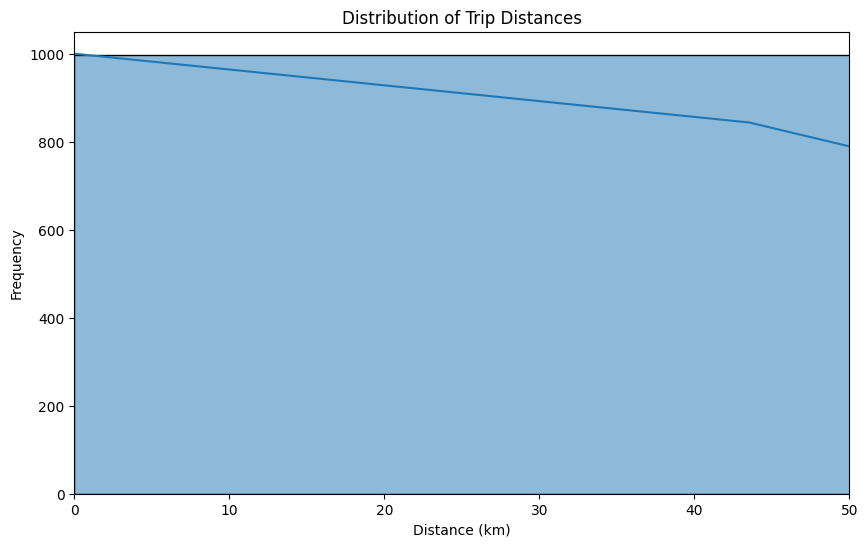

In [11]:
# Distribution of distance
plt.figure(figsize=(10, 6)) 
sns.histplot(df['distance_km'], bins=50, kde=True)
plt.title('Distribution of Trip Distances')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.xlim(0, 50)
plt.show()

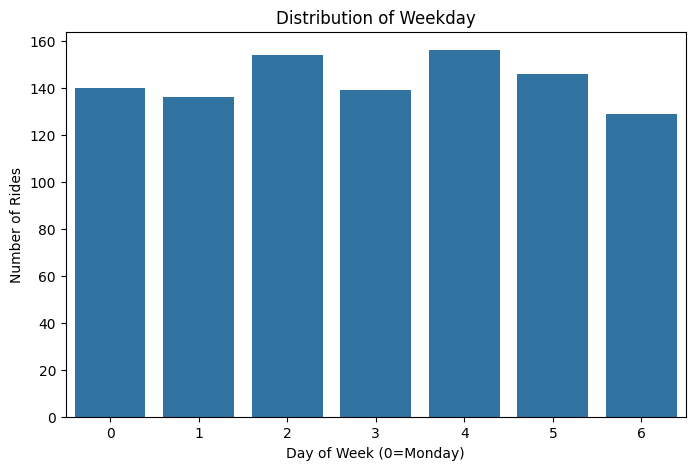

In [12]:
# Extract datetime features if not already present
if 'day_of_week' not in df.columns:
	df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True)
	df['day_of_week'] = df['pickup_datetime'].dt.dayofweek

# Distribution of weekday
plt.figure(figsize=(8, 5))
sns.countplot(x='day_of_week', data=df)
plt.title("Distribution of Weekday")
plt.xlabel("Day of Week (0=Monday)")
plt.ylabel("Number of Rides")
plt.show()

In [13]:
# Extract datetime features
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], utc=True)
df['hour'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)


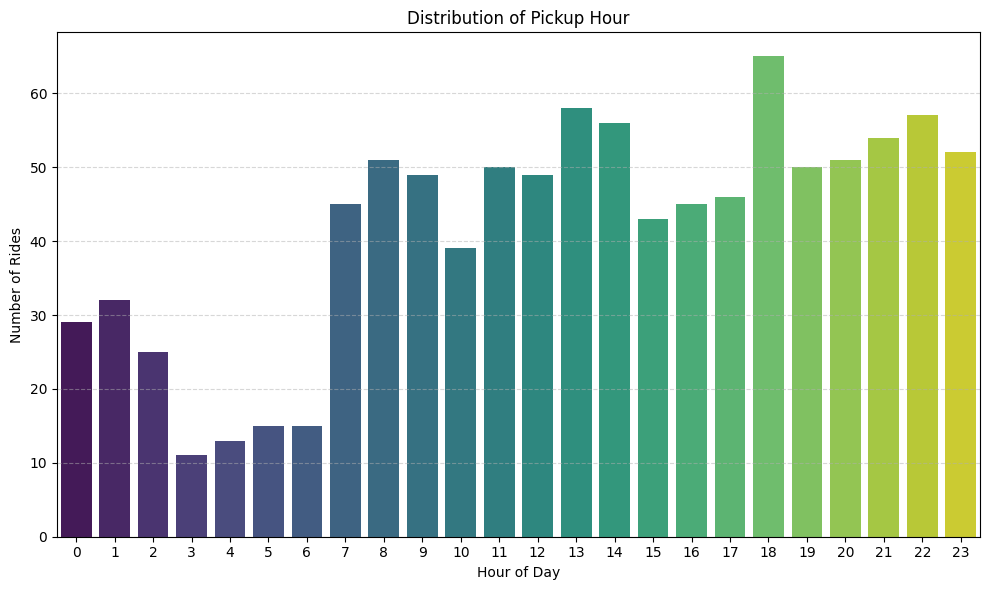

In [14]:


# Assuming your DataFrame `df` has a 'pickup_datetime' column
# and you want to extract the hour from it
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['hour'] = df['pickup_datetime'].dt.hour

# Plotting
plt.figure(figsize=(10, 6))
sns.countplot(x='hour', data=df, palette='viridis')
plt.title("Distribution of Pickup Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Rides")
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


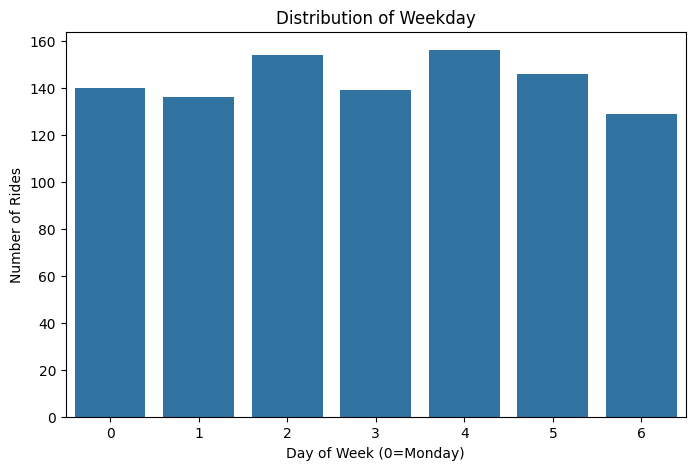

In [15]:
# Distribution of weekday
plt.figure(figsize=(8, 5))
sns.countplot(x=df['day_of_week'])
plt.title("Distribution of Weekday")
plt.xlabel("Day of Week (0=Monday)")
plt.ylabel("Number of Rides")
plt.show()

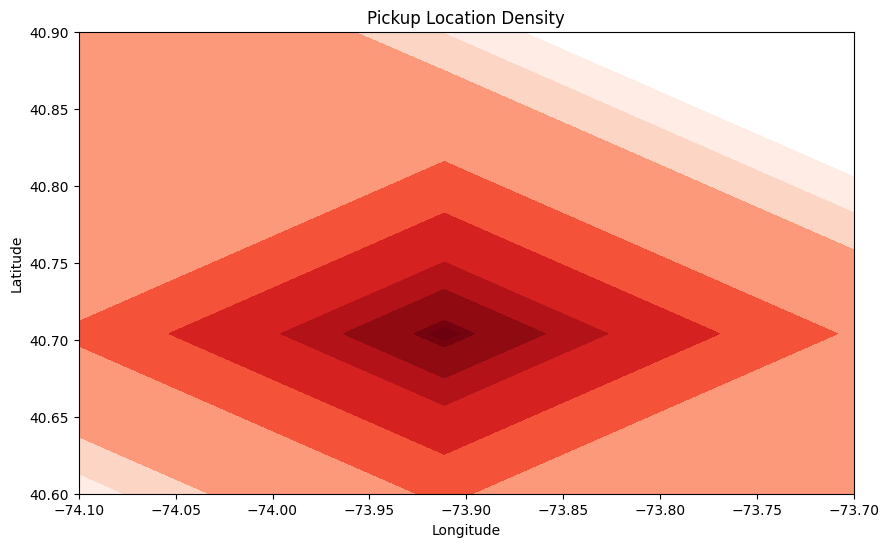

In [16]:
# Pickup and dropoff density heatmaps (scatterplots)
plt.figure(figsize=(10, 6))
sns.kdeplot(x=df['pickup_longitude'], y=df['pickup_latitude'], cmap="Reds", fill=True, bw_adjust=.5)
plt.title("Pickup Location Density")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim(-74.1, -73.7)
plt.ylim(40.6, 40.9)
plt.show()


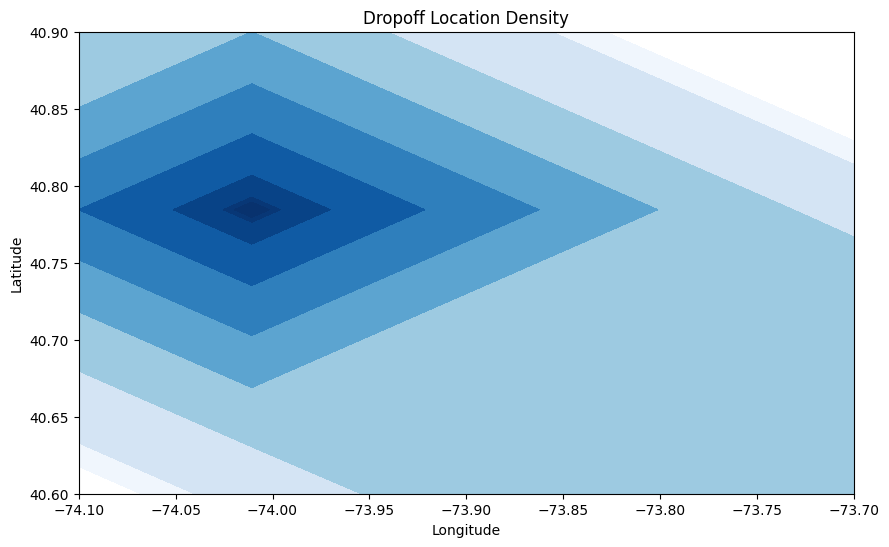

In [17]:
plt.figure(figsize=(10, 6))
sns.kdeplot(x=df['dropoff_longitude'], y=df['dropoff_latitude'], cmap="Blues", fill=True, bw_adjust=.5)
plt.title("Dropoff Location Density")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim(-74.1, -73.7)
plt.ylim(40.6, 40.9)
plt.show()

In [18]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

df['hour'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)


In [19]:
from geopy.distance import geodesic

def calculate_distance(row):
    pickup = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
    return geodesic(pickup, dropoff).km

df['distance_km'] = df.apply(calculate_distance, axis=1)


In [20]:
#  Select Features and Target
features = ['passenger_count', 'hour', 'day_of_week', 'is_weekend', 'distance_km']


In [21]:
X = df[features]
y = df['fare_amount']

In [22]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
# Modeling & Comparison
def evaluate_model(name, model):
    scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=3)
    rmse_scores = -scores
    print(f"{name} Average CV RMSE: {rmse_scores.mean():.2f}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{name} Test RMSE: {rmse:.2f}\n")

In [24]:
# Evaluate various models
evaluate_model("Linear Regression", LinearRegression())
evaluate_model("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42))
evaluate_model("XGBoost", xgb.XGBRegressor(n_estimators=100, random_state=42))
evaluate_model("LightGBM", lgb.LGBMRegressor(n_estimators=100, random_state=42))
evaluate_model("MLP Regressor", MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=10, random_state=42))

Linear Regression Average CV RMSE: 407.40
Linear Regression Test RMSE: 8.41

Random Forest Average CV RMSE: 5.82
Random Forest Test RMSE: 5.28

XGBoost Average CV RMSE: 6.34
XGBoost Test RMSE: 5.44

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 533, number of used features: 5
[LightGBM] [Info] Start training from score 11.880901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

In [25]:
# Save the Best Model
best_model = RandomForestRegressor(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)
joblib.dump(best_model, 'taxi_fare_model.pkl')
print(" Model trained and saved as 'taxi_fare_model.pkl'")

 Model trained and saved as 'taxi_fare_model.pkl'


In [26]:
print("Accuracy of model - Train: {:.2f} %".format(best_model.score(X_train, y_train)*100)) 

Accuracy of model - Train: 94.77 %
